# Imports and settings

In [126]:
import adaptive_latents as al
from adaptive_latents import mmICA, sjPCA, proSVD, CenteringTransformer, Pipeline, NumpyTimedDataSource
import matplotlib.pyplot as plt
import numpy as np
from datasets import Leventhal24uDataset
from picard import permute

rng = np.random.default_rng(0)


In [74]:
plt.rc('lines', linewidth=2)
plt.rc('font', family='arial')


# Simulated data

In [193]:
dt = 0.03 # seconds
log_y = True
colors = ["#F94B00", "#2FA194", "#903F65"]

## sjPCA

Text(0.5, 1.0, 'sjPCA error')

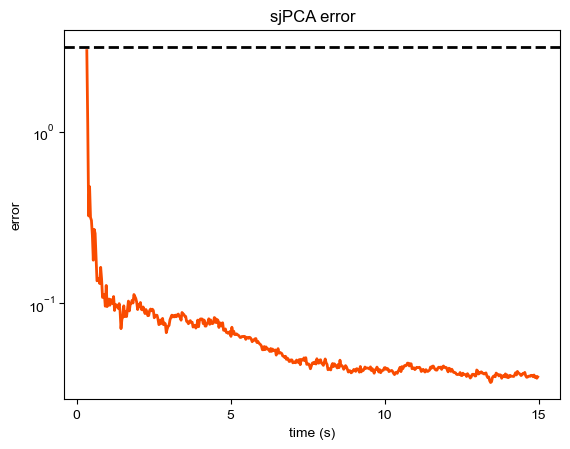

In [198]:
X, _, true_variables = al.jpca.generate_circle_embedded_in_high_d(rng, m=500, n=8, stddev=1)
jp = sjPCA(log_level=1)
jp.offline_run_on(NumpyTimedDataSource(X, timepoints = np.arange(X.shape[0]) * dt))

distances, t = jp.get_distance_from_subspace_over_time(true_variables['C'])

fig, ax = plt.subplots()
ax.plot(t, distances[:,0], color=colors[0])
ax.set_xlabel('time (s)')
ax.set_ylabel('error') # the error is the sum of (the absolute values of) the principal angles between the correct and discovered subspaces
ax.axhline(2 * np.pi/2, color='k', linestyle = '--')
ax.set_xticks([0,5,10,15])

if log_y:
    ax.semilogy()
    ax.set_yticks([1, .1])
    ax.minorticks_off()
else:
    ax.set_yticks([0,1,2,3])
ax.set_title("sjPCA error")



## mmICA

In [195]:
ica = mmICA(alpha=.5, maxiter_cg=20, tol=1e-20, log_level=1)
m = 1_000 # number of blocks
n = 6 # size of each block
input_data = NumpyTimedDataSource(rng.laplace(size=(m, n, n)), timepoints = np.arange(m) * n * dt )

ica.offline_run_on(input_data);


Text(0.5, 1.0, 'mmICA error')

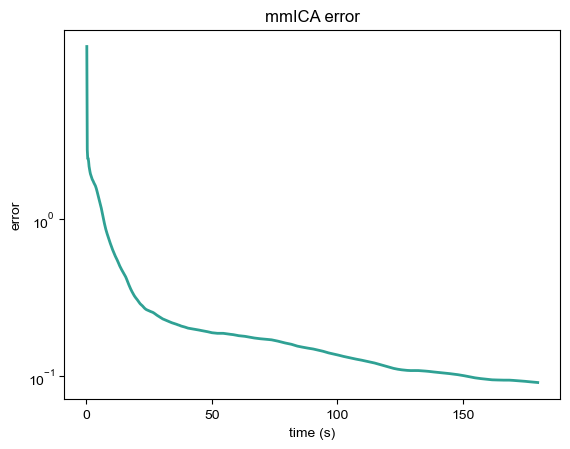

In [203]:
ts = []
errors = []
for W, t in zip(ica.log['W'], ica.log['t'], strict=True):
    ts.append(t)
    error = permute(W) - np.eye(W.shape[0])
    errors.append(np.linalg.norm(error))
ts = np.squeeze(ts)
errors = np.squeeze(errors)

fig, ax = plt.subplots()
ax.plot(ts, errors, color=colors[1])
ax.set_xlabel('time (s)')
ax.set_ylabel('error')
ax.set_xticks([0,50,100,150])

if log_y:
    ax.semilogy()
    ax.set_yticks([1, .1])
    ax.minorticks_off()
else:
    ax.set_yticks([0,1,2])

ax.set_title("mmICA error")


## proSVD

Text(0.5, 1.0, 'proSVD error')

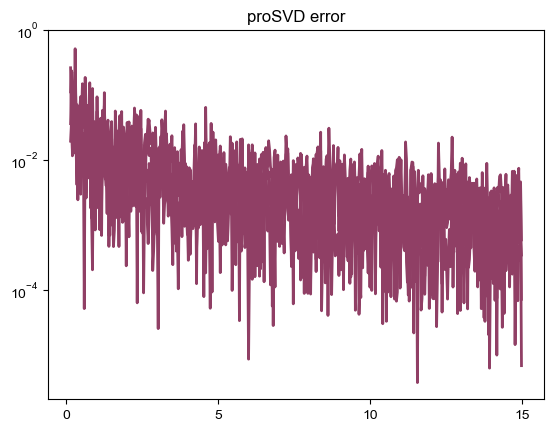

In [202]:
X, _, true_variables = al.jpca.generate_circle_embedded_in_high_d(rng, m=500, n=8, stddev=1)
pro = proSVD(k=4, log_level=1)

pro.offline_run_on(NumpyTimedDataSource(X, timepoints=np.arange(X.shape[0]) * dt))

fig, ax = plt.subplots()

dQ, t = pro.get_Q_stability()
ax.plot(t, dQ, color=colors[2])
ax.set_xticks([0,5,10,15])

if log_y:
    ax.semilogy()
    ax.set_yticks([1e0, 1e-2, 1e-4])
    ax.minorticks_off()
else:
    ax.set_yticks([0,.5])

ax.set_title("proSVD error")



# Real data

In [23]:
%%capture 
d = Leventhal24uDataset(); # the official function I found to load some of the files annoyingly has print statements

In [14]:
jp = sjPCA(log_level=1)

pipeline = Pipeline([
    CenteringTransformer(),
    proSVD(k=6),
    jp
])

pipeline.offline_run_on(d.neural_data)

distances, t = jp.get_distance_from_subspace_over_time(jp.log['U'][-1][:,0:2])
plt.plot(t, distances)
# plt.semilogy()


/home/jgould/Documents/AdaptiveLatents/adaptive_latents/utils.py:240: RuntimeWarning: invalid value encountered in arccos
  return np.acos(s)


In [19]:
d.neural_data.t[-1]

np.float64(3606.8593999999994)